In [1]:
%pylab inline
import torch
import torch.nn as nn

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    
#Move tensors around using the .to(device) command
tensor_on_device = torch.ones(1).to(device)
print(tensor_on_device.device)

No GPU available!
cpu


# Definiendo la función objetivo

In [13]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def ackley(x, y):
    #sum_sq_term = -20 * np.exp(-0.2*np.sqrt(0.5*(x*x+y*y)))
    #cos_term = -np.exp(0.5*(np.cos(2*np.pi*x)+np.cos(2*np.pi*y)))
    #value = sum_sq_term+cos_term+np.exp(1)+20
    value = x**2 + y**2
    return value

### 1.2: Use your previous defined method to plot the function in 3d in the range $(x, y)\in [-5, 5]$

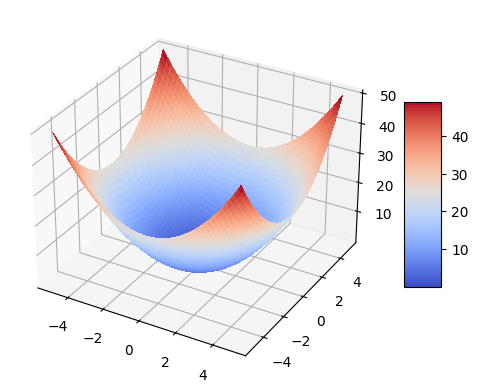

In [14]:
def plot_ackley_3d(x, y):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x, y = np.meshgrid(x, y)
    # Plot the surface.
    z = ackley(x, y)
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                                   linewidth=0, antialiased=False)

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
plot_ackley_3d(x, y)

### 1.3: Use your previous defined method Plot the function in 3d in the range $(x, y) \in [-32, 32]$

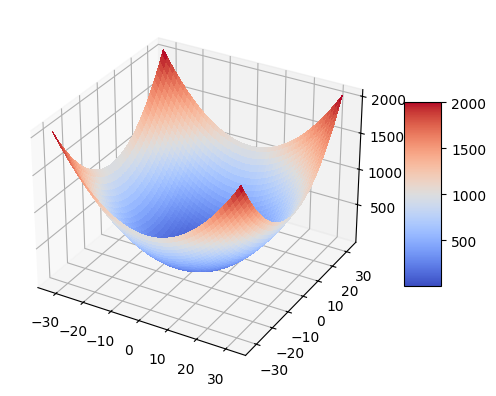

In [15]:
x = np.linspace(-32, 32, 100)
y = np.linspace(-32, 32, 100)

plot_ackley_3d(x, y)

### 1.4: What do you observe about this function? Why do you think this function is a test problem for optimization?

## Task 2: The Ackley Function in Pytorch, Autograd and Gradient Descent

- 2.1: Define the Ackley-Function as a pytorch nn.Module class
- 2.2: Try to find the global minimum (solution: 0., 0.) of the Ackley function with Gradient Descent (```torch.optim.SGD```) from a random starting position. Use torch.randn to obtain a sample from a Gaussian.
    - Store and plot the corresponding function value as a function of the iteration number (ackley(x) vs. iteration)
    - Store and plot the norm of the gradients during optimization.
- 2.3: For 10 random starting positions (```torch.randn```) plot the Ackley function in 2D and the optimization trajectories together:
    - Do you reach a global minimum?
    - What do you observe for the various optimization trajectories.
    
### 2.1: Define the Ackley-Function as a pytorch nn.Module class

In [6]:
class Ackley(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, coords):
        x = coords[:, 0]
        y = coords[:, 1]
        #sum_sq_term = -20 * torch.exp(-0.2*torch.sqrt(0.5*(x*x+y*y)))
        #cos_term = -torch.exp(0.5*(torch.cos(2*np.pi*x)+torch.cos(2*np.pi*y)))
        #value = sum_sq_term+cos_term+np.exp(1)+20
        value = x**2 + y**2
        return value


### 2.2: Try to find the global minimum (solution: 0., 0.) of the Ackley function with Gradient Descent 

Text(0, 0.5, 'Gradient Norm')

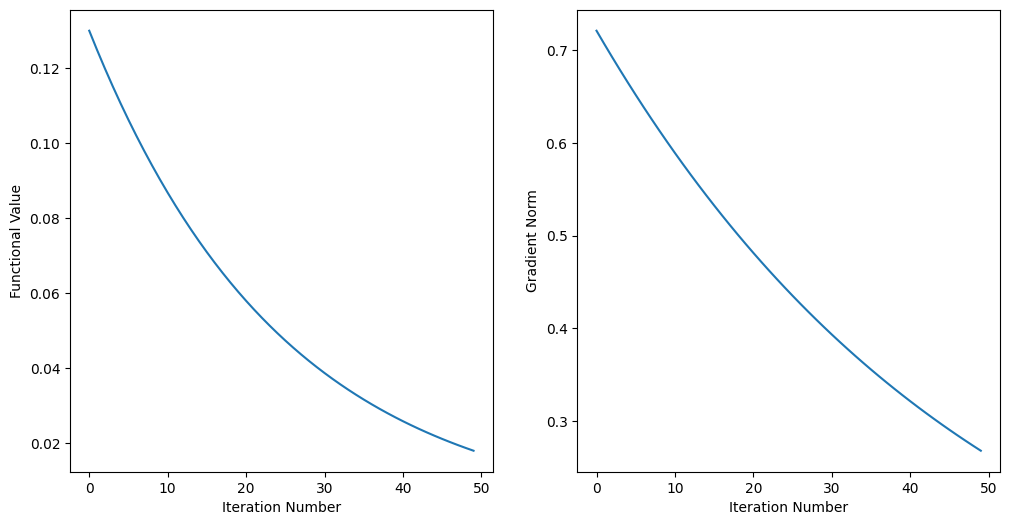

In [7]:
set_seed(42)   
ackley_torch = Ackley()

coords = torch.randn(1, 2, requires_grad=True) #Se usan aleatoriamente coordenadas de la función objetivo
optimizer = torch.optim.SGD([coords], lr=1e-2) #Se usa el optimizador SGD con una tasa de aprendizaje de 1e-2
steps = [] #Se almacenan los valores de la función objetivo
grads = [] #Se almacenan los valores de la norma del gradiente
for i in range(50):
    optimizer.zero_grad() #Se reinicia el gradiente
    f = ackley_torch(coords) #Se evalúa la función objetivo
    f.backward() #Se calcula el gradiente
    optimizer.step() #Se actualizan los parámetros
    steps.append(f.detach().numpy().copy()) #Se almacena el valor de la función objetivo
    grads.append(coords.grad.norm().detach().numpy().copy()) #Se almacena el valor de la norma del gradiente
    
fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(steps)
ax[0].set_xlabel("Iteration Number")
ax[0].set_ylabel("Functional Value")
ax[1].plot(grads)
ax[1].set_xlabel("Iteration Number")
ax[1].set_ylabel("Gradient Norm")

### 2.3: For 10 random starting positions (```torch.randn```) plot the Ackley function in 2D and the optimization trajectories together:

In [8]:
set_seed(42)
ackley_torch = Ackley()

attempts = []
for j in range(100):
    coords = torch.randn(1, 2)*2
    coords.requires_grad = True
    optimizer = torch.optim.SGD([coords], lr=1e-1)
    steps = [coords.detach().numpy().copy()]
    for i in range(50):
        optimizer.zero_grad()
        f = ackley_torch(coords)
        f.backward()
        optimizer.step()
        steps.append(coords.detach().numpy().copy())
    attempts.append(steps)

(-3.0, 3.0)

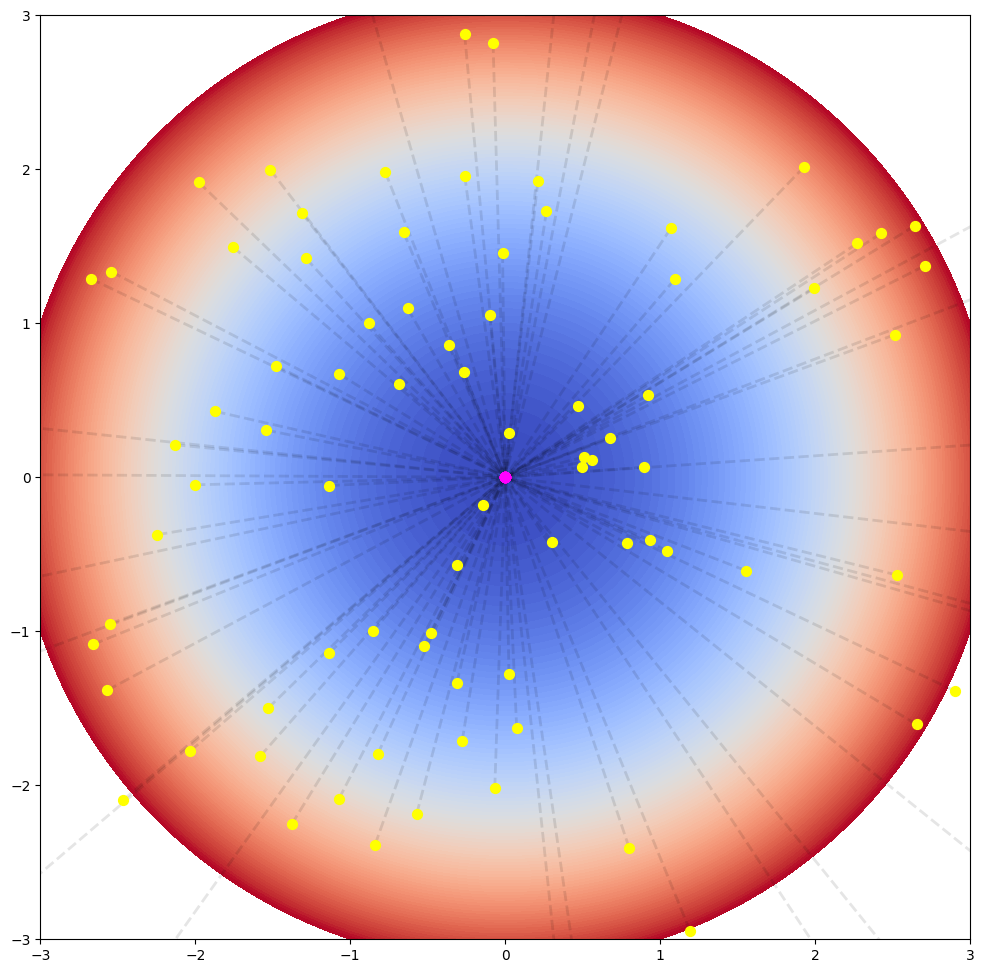

In [9]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Make data.
x, y = np.meshgrid(x, y)

z = ackley(x, y)

# Plot the surface.
surf = ax.contourf(x, y, z, np.linspace(0, 10, 100), cmap=cm.coolwarm)
for a in attempts:
    steps_np = np.array(a)[:, 0, :]
    ax.plot(steps_np[:, 0], steps_np[:, 1], linewidth=2, c="black", linestyle="--", alpha=0.1)
    
for a in attempts:
    steps_np = np.array(a)[:, 0, :]
    ax.scatter(steps_np[[0], 0], steps_np[[0], 1], marker="o", color="yellow", s=50, zorder=100)
    ax.scatter(steps_np[[-1], 0], steps_np[[-1], 1], marker="o", color="magenta", s=50, zorder=100)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

## Usando Momentum

Text(0, 0.5, 'Gradient Norm')

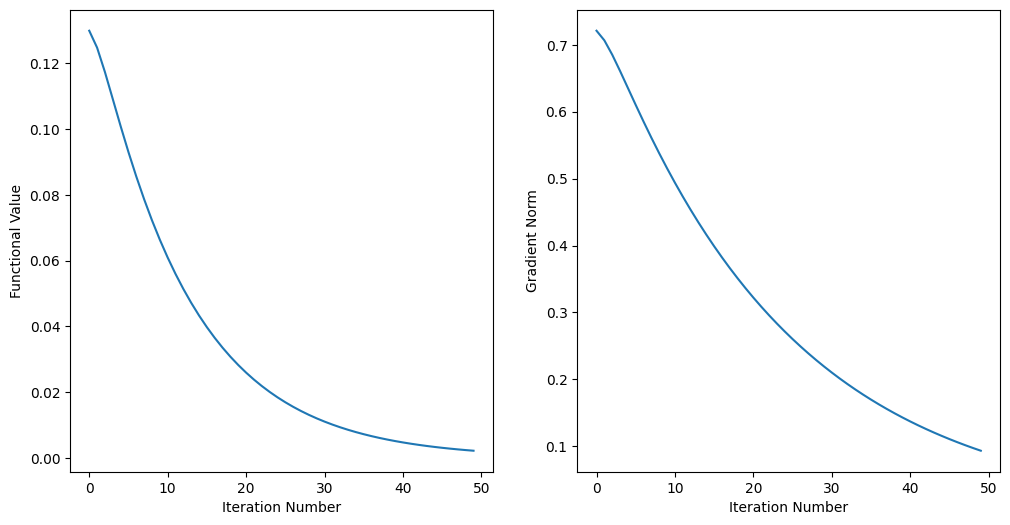

In [26]:
set_seed(42)   
ackley_torch = Ackley()

coords = torch.randn(1, 2, requires_grad=True) # Se usan aleatoriamente las coordenadas
optimizer = torch.optim.SGD([coords], lr=1e-2, momentum=0.5) #Se define el momento del optimizador
steps = []
grads = []
for i in range(50):
    optimizer.zero_grad()
    f = ackley_torch(coords)
    f.backward()
    optimizer.step()
    steps.append(f.detach().numpy().copy())
    grads.append(coords.grad.norm().detach().numpy().copy())
    
fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(steps)
ax[0].set_xlabel("Iteration Number")
ax[0].set_ylabel("Functional Value")
ax[1].plot(grads)
ax[1].set_xlabel("Iteration Number")
ax[1].set_ylabel("Gradient Norm")

In [31]:
set_seed(42)
ackley_torch = Ackley()

attempts = []
for j in range(100):
    coords = torch.randn(1, 2)*2
    coords.requires_grad = True
    optimizer = torch.optim.SGD([coords], lr=1e-1, momentum=0.5)
    steps = [coords.detach().numpy().copy()]
    for i in range(50):
        optimizer.zero_grad()
        f = ackley_torch(coords)
        f.backward()
        optimizer.step()
        steps.append(coords.detach().numpy().copy())
    attempts.append(steps)

(-3.0, 3.0)

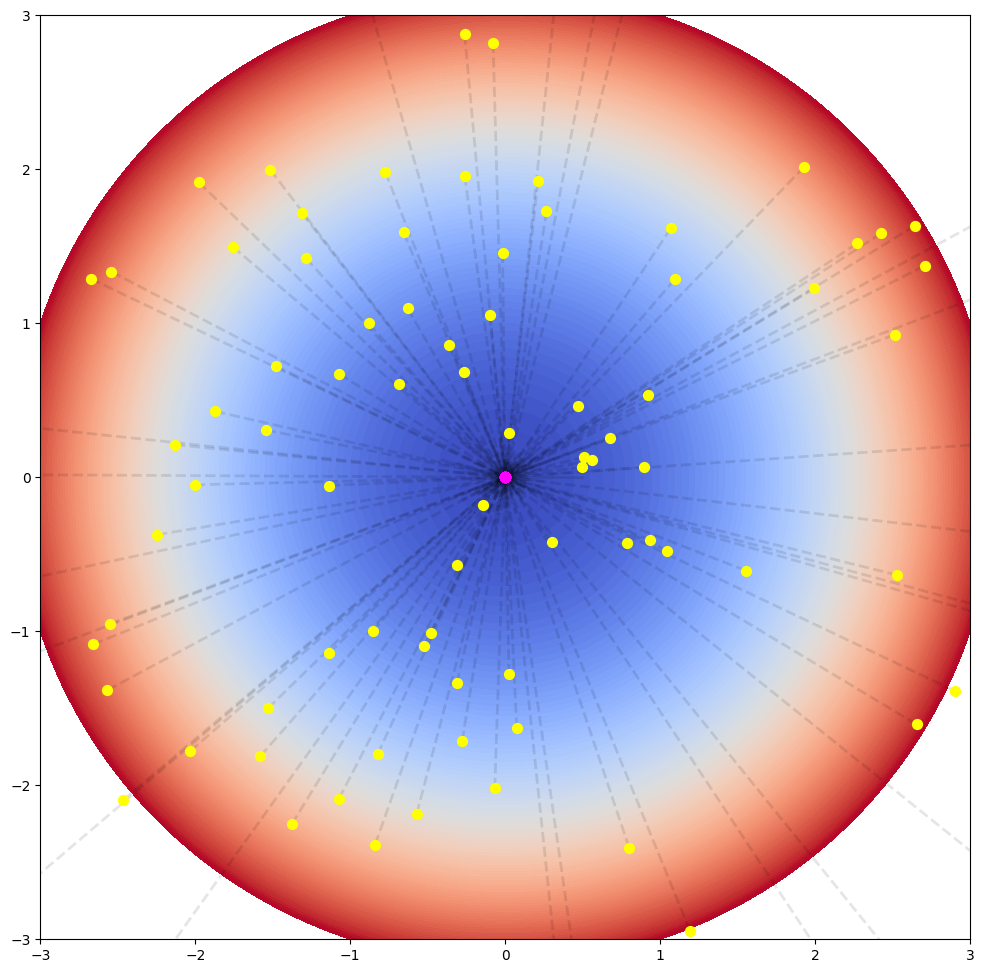

In [32]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Make data.
x, y = np.meshgrid(x, y)

z = ackley(x, y)

# Plot the surface.
surf = ax.contourf(x, y, z, np.linspace(0, 10, 100), cmap=cm.coolwarm)
for a in attempts:
    steps_np = np.array(a)[:, 0, :]
    ax.plot(steps_np[:, 0], steps_np[:, 1], linewidth=2, c="black", linestyle="--", alpha=0.1)
    
for a in attempts:
    steps_np = np.array(a)[:, 0, :]
    ax.scatter(steps_np[[0], 0], steps_np[[0], 1], marker="o", color="yellow", s=50, zorder=100)
    ax.scatter(steps_np[[-1], 0], steps_np[[-1], 1], marker="o", color="magenta", s=50, zorder=100)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)